# Contours


**All related features to contours:**

- [Find contours](#Find-Contours)
- [Draw contours](#Draw-Contours)
- [Approximate contours](#contour-approximation--shape-matching--area)
    - [Optimizing Approximation](#optimzing-appoximation)
        - [Function Usage](#optimapproxpoly-function-usage)
    - [Window Approximation](#window-approximation)
- [Convex, Defects & Hull](#convex-defects--hull)
- [Bounding contour with shapes](#bounding)
- [Centroid](#centroid)
- [Inverse and Non-inverse Binary Images Give Different Number of Contours](#inverse-and-non-inverse-binary-images-give-different-number-of-contours)


**References:**

https://docs.opencv.org/4.x/d3/d05/tutorial_py_table_of_contents_contours.html

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import utils


## Sample Image
Load image in gray scale because the following operations require gray scale and binary image (boolean) image.

In [2]:
filename = "detect_blob.png"

In [3]:
filepath = f"sample-data/{filename}"
try:
    utils.getCvSample(filename, filepath)
except:
    assert os.path.isfile(filepath), FileNotFoundError(filepath)
print("Source image file:", filepath)

# NOTE Alternative function but somehow this does not work
# cv2.samples.findFile("smarties.png")


Source image file: sample-data/detect_blob.png


In [4]:
crop = [500,650,150,280] # y1,y2,x1,x2

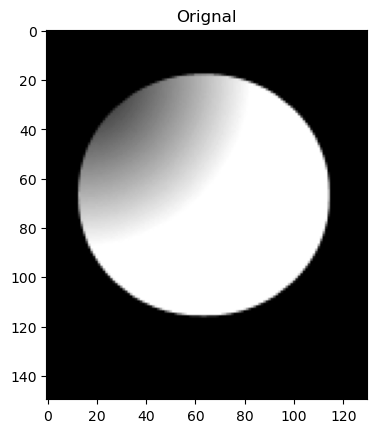

(<matplotlib.image.AxesImage at 0x150780650>, Text(0.5, 1.0, 'Orignal'), None)

In [5]:
orgImg = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
orgImg = orgImg[crop[0]:crop[1]:,crop[2]:crop[3]]
plt.imshow(orgImg, 'gray'), plt.title("Orignal"), plt.show()

## Binarization
Binarizing an image is to turn pixel values into only two values (aka boolean image). There are many methods such as `compare`, `inRange`, `threshold`, `adaptiveThreshold` and `Canny` etc.

The main reason why we need binarization at the first step is to distinguish between background and foreground, where backgound is marked as 0 and foreground is marked as 255.

In this example, I use `threshold`. `THRESH_OTSU` is chosen as the threholding method for binarization. See Otsu's binarization explanation in https://docs.opencv.org/4.x/d7/d4d/tutorial_py_thresholding.html and below figure.

<img src="https://docs.opencv.org/4.x/otsu.jpg" height=300/>

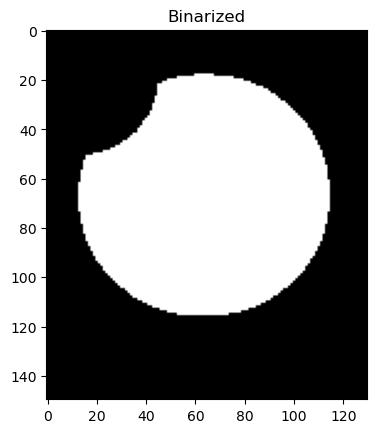

(150, 130)


In [6]:
_, thresMat = cv2.threshold(orgImg, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
plt.imshow(thresMat, 'gray'), plt.title("Binarized"), plt.show()
print(thresMat.shape)

## Find Contours

In [7]:
# find contours
contours, hierarchy = cv2.findContours(thresMat, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
print("Found", len(contours), "contours.")

Found 1 contours.


## Draw Contours

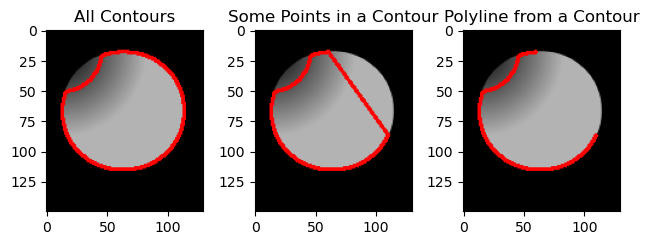

In [8]:
plt.subplot(1,3,1)
plt.imshow(cv2.drawContours(cv2.cvtColor(orgImg, cv2.COLOR_GRAY2RGB), contours, -1, (255,0,0), 2))
plt.title("All Contours")

plt.subplot(1,3,2)
plt.imshow(cv2.drawContours(cv2.cvtColor(orgImg, cv2.COLOR_GRAY2RGB), [contours[0][:100]], -1, (255,0,0), 2))
plt.title("Some Points in a Contour")

plt.subplot(1,3,3)
plt.imshow(cv2.polylines(cv2.cvtColor(orgImg, cv2.COLOR_GRAY2RGB), [contours[0][:100]], False, (255,0,0), 2))
plt.title("Polyline from a Contour")

plt.tight_layout()
plt.show()

## Contour Approximation & Shape Matching & Area
`approxPolyDP` is to approximate a contour, i.e. reduce number of tmpVertices.

`matchShapes` is to match between two contours, where lower score, more matching.

In [9]:
eps1 = 0.01
eps2 = 0.1

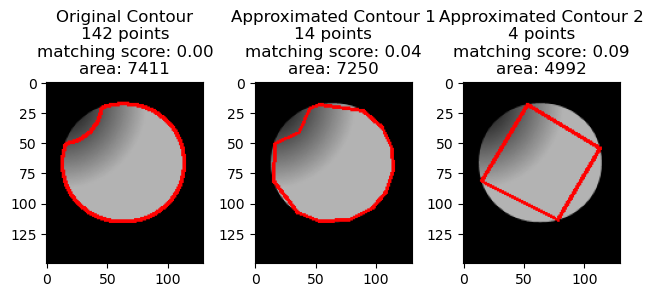

In [10]:
orgMatchScore = cv2.matchShapes(contours[0], contours[0], cv2.CONTOURS_MATCH_I1, 0)
orgNum = len(contours[0])
orgArea = cv2.contourArea(contours[0])

# reduce vertices by approximating a contour
eps = eps1*cv2.arcLength(contours[0], True)
approx1 = cv2.approxPolyDP(contours[0] ,eps, True)
matchScore1 = cv2.matchShapes(contours[0], approx1, cv2.CONTOURS_MATCH_I1, 0)
approxNum1 = len(approx1)
approxArea1 = cv2.contourArea(approx1)

eps = eps2*cv2.arcLength(contours[0], True)
approx2 = cv2.approxPolyDP(contours[0] ,eps, True)
matchScore2 = cv2.matchShapes(contours[0], approx2, cv2.CONTOURS_MATCH_I1, 0)
approxNum2 = len(approx2)
approxArea2 = cv2.contourArea(approx2)

plt.subplot(1,3,1)
plt.imshow(cv2.drawContours(cv2.cvtColor(orgImg, cv2.COLOR_GRAY2RGB), contours, 0, (255,0,0), 2))
plt.title(f"Original Contour\n{orgNum} points\nmatching score: {orgMatchScore:.2f}\narea: {orgArea:.0f}")

plt.subplot(1,3,2)
plt.imshow(cv2.drawContours(cv2.cvtColor(orgImg, cv2.COLOR_GRAY2RGB), [approx1], -1, (255,0,0), 2))
plt.title(f"Approximated Contour 1\n{approxNum1} points\nmatching score: {matchScore1:.2f}\narea: {approxArea1:.0f}")

plt.subplot(1,3,3)
plt.imshow(cv2.drawContours(cv2.cvtColor(orgImg, cv2.COLOR_GRAY2RGB), [approx2], -1, (255,0,0), 2))
plt.title(f"Approximated Contour 2\n{approxNum2} points\nmatching score: {matchScore2:.2f}\narea: {approxArea2:.0f}")

plt.tight_layout()
plt.show()

### Optimzing Appoximation
Iterate until reach area difference reaches threshold.

In [11]:
maxAreaDiff = 0.01
startE = 0.001
stepE = 0.001
maxIter = 15

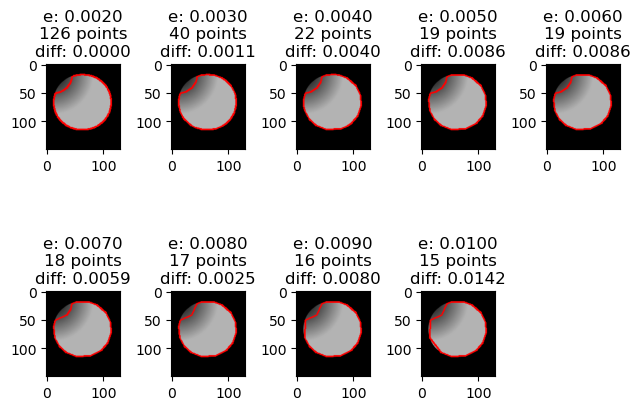

(None, None)

In [12]:
# reduce vertices by approximating a contour until area reach min level
areaDiff = 0.0
e = startE
i = 0
approxList = []
while (areaDiff < maxAreaDiff and i < maxIter):
    approxList.append({})
    approxList[i]['eps'] = e*cv2.arcLength(contours[0], True)
    approxList[i]['approx'] = cv2.approxPolyDP(contours[0] ,approxList[i]['eps'], True)
    areaDiff = np.abs(cv2.contourArea(approxList[i]['approx']) - cv2.contourArea(contours[0])) / cv2.contourArea(contours[0])
    approxList[i]['diff'] = areaDiff
    e += stepE
    approxList[i]['e'] = e
    i += 1

c = 5
r = (len(approxList) // 5) + 1 if len(approxList) % c else len(approxList) // 5
for i in range(len(approxList)):
    plt.subplot(r,c,i+1)
    plt.imshow(cv2.drawContours(cv2.cvtColor(orgImg, cv2.COLOR_GRAY2RGB), [approxList[i]['approx']], -1, (255,0,0), 2))
    plt.title(f"e: {approxList[i]['e']:.4f}\n{len(approxList[i]['approx'])} points\ndiff: {approxList[i]['diff']:.4f}")
plt.tight_layout(), plt.show()

#### `optimApproxPoly` Function Usage

In [13]:
utils.optimApproxPoly(contours[0], maxAreaDiff, startE, stepE, maxIter, True)
# utils.iterOptimApproxPoly # for whole contours

From area 7411.0 to 7305.5.
From vertice count 142 to 15.
e = 0.010000000000000002
eps = 2.9840714092254643
area diff = 0.014235595736068007


(array([[[ 53,  19]],
 
        [[ 45,  22]],
 
        [[ 36,  42]],
 
        [[ 16,  51]],
 
        [[ 15,  82]],
 
        [[ 35, 108]],
 
        [[ 53, 115]],
 
        [[ 78, 114]],
 
        [[ 97, 104]],
 
        [[108,  91]],
 
        [[114,  73]],
 
        [[113,  55]],
 
        [[105,  38]],
 
        [[ 89,  24]],
 
        [[ 75,  19]]], dtype=int32),
 0.010000000000000002,
 2.9840714092254643,
 0.014235595736068007)

### Window Approximation
Slide window around a contour's vertice, and approximate each window.

Contours 2
Vertice 126


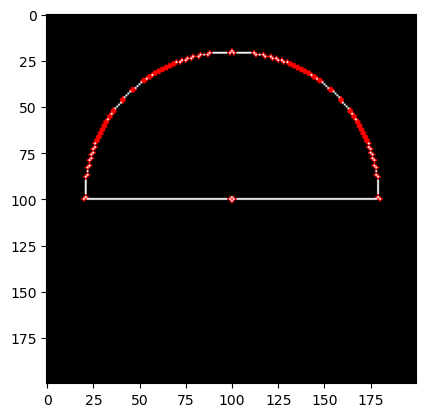

(<matplotlib.image.AxesImage at 0x150d51490>, None)

In [14]:
dummyImg1 = np.zeros((200,200), np.uint8)
dummyImg1 = cv2.circle(dummyImg1, (100,100), 80, 255, 1)
dummyImg1[100:] = 0
dummyImg1 = cv2.line(dummyImg1, (20,100), (180,100), 255, 1)
dummyImg1 = cv2.circle(dummyImg1, (100,100), 1, 255 , 1)

contours1, _ = cv2.findContours(dummyImg1, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# contours1, _ = cv2.findContours(dummyImg1, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
print("Contours", len(contours1))
print("Vertice", len(contours1[0]))

img = np.zeros(list(dummyImg1.shape) + [3], np.uint8)
img = cv2.drawContours(img, contours1, -1, (255,255,255), 1)
for pt in contours1[0]:
    img = cv2.circle(img, pt[0], 1, (255,0,0), 1)
plt.imshow(img), plt.show()

In [15]:
def getFragment(vertice: np.ndarray, i: int, windowSize: int):
    diffLen =  i + windowSize - len(vertice)
    if diffLen > 0:
        return np.concatenate([vertice[i:], vertice[:diffLen]])
    else:
        return vertice[i : i + windowSize]
    
    
def optimApprox(orgCnt: int,
                orgArcLen: int,
                orgArea: int,
                tmpVertice: np.ndarray, 
                tmpCnt: int,
                tmpArcLen: int,
                fragVertice: np.ndarray, 
                fragCnt: int,
                fragArcLen: int,
                windowSize: int,
                startE: float, 
                stepE: float,
                maxErr: float,
                verboseLv: int = 0):
    # init.
    diffLen =  i + windowSize - tmpCnt
    approxFragVertice = fragVertice
    approxVertice = tmpVertice
    approxCnt = orgCnt
    approxArea = orgArea
    err = 0.0
    tmpE = startE
    e = 0.0
    
    while True:
        # approximate.
        tmpApproxFragVertice = cv2.approxPolyDP(fragVertice , tmpE * fragArcLen, False)
        
        # replace fragement vertice with approximated vertice in the original contour.
        if diffLen > 0:
            tmpApproxVertice = np.concatenate([tmpVertice[diffLen:i], tmpApproxFragVertice])
        else:
            tmpApproxVertice = np.concatenate([tmpVertice[:i], tmpApproxFragVertice, tmpVertice[i + windowSize:]])
        
        # find area.
        tmpApproxCnt = len(tmpApproxVertice)
        tmpApproxArea = cv2.contourArea(tmpApproxVertice)
        tmpErr = abs(tmpApproxArea - orgArea) / orgArea
        if verboseLv > 2:
            print("\napprixinating...")
            print(f"e = {tmpE}")
            print(f"Temporary vertice", tmpCnt)
            print(f"Fragment vertice from {fragCnt} to {len(tmpApproxFragVertice)}")
            print(f"Total vertice from {orgCnt} to {tmpApproxCnt}")
            print(f"Area from {orgArea} to {tmpApproxArea} : error rate = {tmpErr}")
            
        # validate area.
        if tmpErr < maxErr:
            approxFragVertice = tmpApproxFragVertice
            approxVertice = tmpApproxVertice
            approxCnt = tmpApproxCnt
            approxArea = tmpApproxArea
            e = tmpE
            tmpE += stepE
            err = tmpErr
        else:
            break
        
    return approxFragVertice, approxVertice, approxCnt, approxArea, e, err
        
        
def approxWindow(orgVertice: np.ndarray, 
               windowSize: int, 
               stride: int, 
               startE: float, 
               stepE: float, 
               maxErr: float, 
               verboseLv: int = 0,
               orgShape: tuple = None):
    # init.
    orgCnt = len(orgVertice)
    orgArcLen = cv2.arcLength(orgVertice, True)
    orgArea = cv2.contourArea(orgVertice)
    tmpVertice = orgVertice.copy()
    i = 0

    while True:
        # init temporary vertice.
        tmpCnt = len(tmpVertice)
        tmpArcLen = cv2.arcLength(tmpVertice, True)
        
        # get fragment contour.
        fragVertice = getFragment(tmpVertice, i, windowSize)
        fragCnt = len(fragVertice)
        fragArcLen = cv2.arcLength(fragVertice, False)
        
        approxFrag, approxVertice, approxLen, approxArea, e, err = optimApprox(
            orgCnt, orgArcLen, orgArea, 
            tmpVertice, tmpCnt, tmpArcLen,
            fragVertice, fragCnt, fragArcLen,
            windowSize,
            startE, stepE, maxErr,
            verboseLv
        )
            
        # check approximation.
        if e == 0.0:
            # this fragment cannot be approximated then skip replacement and slide to next fragment.
            if i >= tmpCnt - 1:
                # passed last vertex then call it done.
                if verboseLv > 0: 
                    print(f"\n- - - Vertex {i} - - - > end")
                break
            else:
                if verboseLv > 0: 
                    print(f"\n- - - Vertex {i} - - - > next")
                i += stride
                continue
            
        # update vertice.
        tmpVertice = approxVertice
        
        # compare contour before/after approximated.
        if verboseLv > 0:
            print(f"\n- - - Vertex {i} - - - > update and next")
            print(f"e = {e}")
            print(f"Temporary vertice", tmpCnt)
            print(f"Fragment vertice from {fragCnt} to {len(approxVertice)}")
            print(f"Total vertice from {orgCnt} to {approxLen}")
            print(f"Area from {orgArea} to {approxArea} : error rate = {err}")
        if verboseLv > 1:
            img = np.zeros(list(orgShape) + [3], np.uint8)
            img = cv2.drawContours(img, [orgVertice], -1, (100,100,100), 1)
            img = cv2.drawContours(img, [tmpVertice], -1, (255,255,255), 1)
            img = cv2.polylines(img, [approxFrag], False, (255,0,0), 1)
            plt.imshow(img), plt.show()
            
        # next
        i += stride
        
    return approxVertice


= = = DONE = = =
Total vertice from 126 to 104


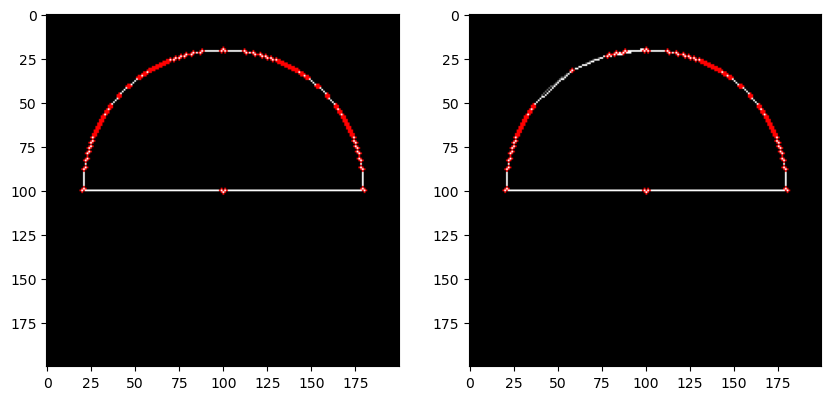

(<Axes: >, <matplotlib.image.AxesImage at 0x150ab7550>, None)

In [16]:
# parameters
orgImage = dummyImg1
orgVertice = contours1[0]
windowSize = 25
# stride = windowSize // 2
stride = windowSize
startE = 0.01
stepE = 0.01
maxErr = 0.002
verboseLv = 0
   

approxVertice = approxWindow(orgVertice, windowSize, stride, startE, stepE, maxErr, verboseLv, orgImage.shape)

print("\n= = = DONE = = =")
print(f"Total vertice from {len(orgVertice)} to {len(approxVertice)}")

img = np.zeros(list(orgImage.shape) + [3], np.uint8)
img = cv2.drawContours(img, [orgVertice], -1, (255,255,255), 1)
for vertex in orgVertice:
    img = cv2.circle(img, vertex[0], 1, (255,0,0), 1)
plt.figure(figsize=(10,16)), plt.subplot(1,2,1), plt.imshow(img)

img = np.zeros(list(orgImage.shape) + [3], np.uint8)
img = cv2.drawContours(img, [orgVertice], -1, (100,100,100), 1)
img = cv2.drawContours(img, [approxVertice], -1, (255,255,255), 1)
for vertex in approxVertice:
    img = cv2.circle(img, vertex[0], 1, (255,0,0), 1)
plt.subplot(1,2,2), plt.imshow(img), plt.show()

## Convex, Defects & Hull

Number of hulls 44
Number of defects: 37


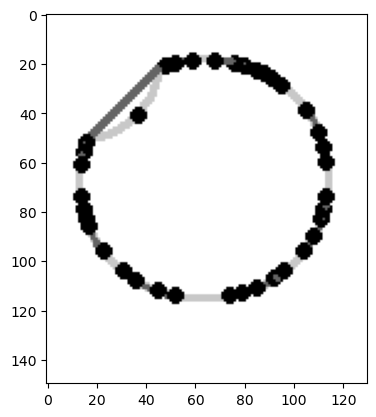

In [17]:
# find hull, convex, defects.
hull = cv2.convexHull(contours[0], returnPoints=True)
print("Number of hulls", len(hull))

regen = np.zeros(orgImg.shape, np.uint8)
regen.fill(255)
regen = cv2.drawContours(regen, [contours[0]], 0, 200, 2)

# hull = cv2.convexHull(contours[0], returnPoints=True) # return hull points in the contour.
hull = cv2.convexHull(contours[0], returnPoints=False) # return indice to points in the contour.
# hullPts = contours[0][hull] # get hull points by hull indice
defects = cv2.convexityDefects(contours[0], hull)
print("Number of defects:", len(defects))
for defect in defects:
    startIdx, endIdx, farIdx, distance = defect[0]
    startPt = tuple(contours[0][startIdx][0]) # equal hullPts[i]
    endPt = tuple(contours[0][endIdx][0]) # equal hullPts[i-1]
    farPt = tuple(contours[0][farIdx][0])
    cv2.line(regen, startPt, endPt, 100, 2)
    cv2.circle(regen, farPt, 2, 0, 2)

plt.imshow(regen, 'gray')
plt.show()

## Bounding

Bounding rectangle => x,y,w,h: 13 18 102 98


/var/folders/xr/fqhbtp7x1fgb6h0skt7fjtfh0000gn/T/ipykernel_47522/853139338.py:13: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)
/var/folders/xr/fqhbtp7x1fgb6h0skt7fjtfh0000gn/T/ipykernel_47522/853139338.py:33: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  triCnt = np.int0(triCnt)
/var/folders/xr/fqhbtp7x1fgb6h0skt7fjtfh0000gn/T/ipykernel_47522/853139338.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lefty = int((-x*vy/vx) + y)
/var/folders/xr/fqhbtp7x1fgb6h0skt7fjtfh0000gn/T/ipykernel_47522/853139338.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this oper

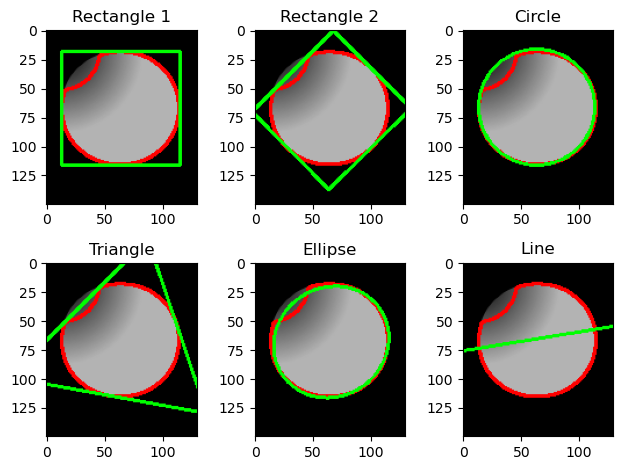

In [18]:
# find bounding rectangle
x,y,w,h = cv2.boundingRect(contours[0])
print("Bounding rectangle => x,y,w,h:",x,y,w,h)
regen = cv2.drawContours(cv2.cvtColor(orgImg, cv2.COLOR_GRAY2RGB), contours, -1, (255,0,0), 2)
regen = cv2.rectangle(regen, (x,y), (x+w,y+h), (0,255,0), 2)
plt.subplot(2,3,1)
plt.imshow(regen)
plt.title(f"Rectangle 1")

# fit bounding rectangle
box = cv2.minAreaRect(contours[0])
box = cv2.boxPoints(box)
box = np.int0(box)
regen = cv2.drawContours(cv2.cvtColor(orgImg, cv2.COLOR_GRAY2RGB), [contours[0]], -1, (255,0,0), 2)
cv2.drawContours(regen, [box], -1, (0,255,0), 2)
plt.subplot(2,3,2)
plt.imshow(regen)
plt.title(f"Rectangle 2")


# fit bounding circle
(x,y), radius = cv2.minEnclosingCircle(contours[0])
center = (int(x),int(y))
radius = int(radius)
regen = cv2.drawContours(cv2.cvtColor(orgImg, cv2.COLOR_GRAY2RGB), [contours[0]], -1, (255,0,0), 2)
cv2.circle(regen, center, radius, (0,255,0), 2)
plt.subplot(2,3,3)
plt.imshow(regen)
plt.title(f"Circle")

# fit bounding triangle
area, triCnt = cv2.minEnclosingTriangle(contours[0])
triCnt = np.int0(triCnt)
regen = cv2.drawContours(cv2.cvtColor(orgImg, cv2.COLOR_GRAY2RGB), [contours[0]], -1, (255,0,0), 2)
regen = cv2.drawContours(regen, [triCnt], -1, (0,255,0), 2)
plt.subplot(2,3,4)
plt.imshow(regen)
plt.title(f"Triangle")

# fit ellipse
elps = cv2.fitEllipse(contours[0])
regen = cv2.drawContours(cv2.cvtColor(orgImg, cv2.COLOR_GRAY2RGB), [contours[0]], -1, (255,0,0), 2)
cv2.ellipse(regen, elps, (0,255,0), 2)
plt.subplot(2,3,5)
plt.imshow(regen)
plt.title(f"Ellipse")

# fit line
rows,cols = orgImg.shape[:2]
[vx,vy,x,y] = cv2.fitLine(contours[0], cv2.DIST_L2, 0, 0.01, 0.01)
lefty = int((-x*vy/vx) + y)
righty = int(((cols-x)*vy/vx)+y)
regen = cv2.drawContours(cv2.cvtColor(orgImg, cv2.COLOR_GRAY2RGB), [contours[0]], -1, (255,0,0), 2)
cv2.line(regen, (cols-1,righty), (0,lefty), (0,255,0), 2)
plt.subplot(2,3,6)
plt.imshow(regen)
plt.title(f"Line")

plt.tight_layout()
plt.show()

## Centroid
Find moments of a single contour then calucate centroid from the moments.


**References**:

https://docs.opencv.org/3.4/d3/dc0/group__imgproc__shape.html#ga556a180f43cab22649c23ada36a8a139


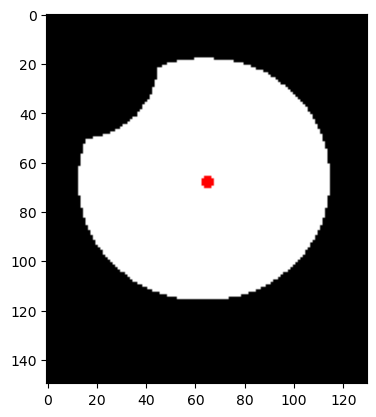

In [19]:
m = cv2.moments(contours[0])
cntPt = (int(m['m10']/m['m00']), int(m['m01']/m['m00'])) # (x,y)
img = cv2.cvtColor(thresMat, cv2.COLOR_GRAY2RGB)
img = cv2.circle(img, cntPt, 1, (255,0,0), 2)
plt.imshow(img)
plt.show()

## Inverse and Non-inverse Binary Images Give Different Number of Contours
Non-inverse binary image have one extra contour more than inverse binary image from the exact same image. The reason might be that Non-inverse binary image's background is white or 255 which `findContours` might detect 255 in the background around image frame as a boundary contour, whereas inverse binary image's background is black or 0.

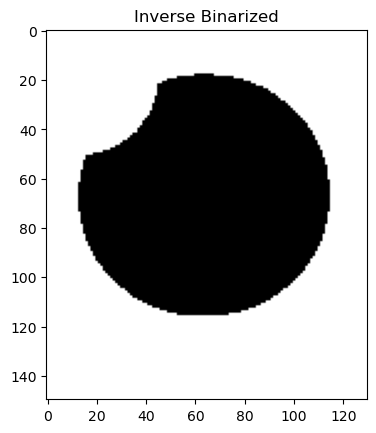

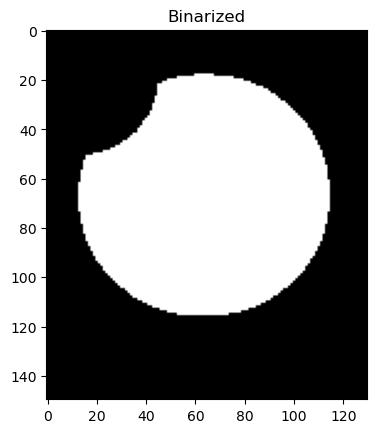

(<matplotlib.image.AxesImage at 0x151975310>,
 Text(0.5, 1.0, 'Binarized'),
 None)

In [20]:
_, biInvMat = cv2.threshold(orgImg, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
_, biMat = cv2.threshold(orgImg, 200, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
plt.imshow(biInvMat, 'gray'), plt.title("Inverse Binarized"), plt.show()
plt.imshow(biMat, 'gray'), plt.title("Binarized"), plt.show()

Number of inverse binarized contours:  2


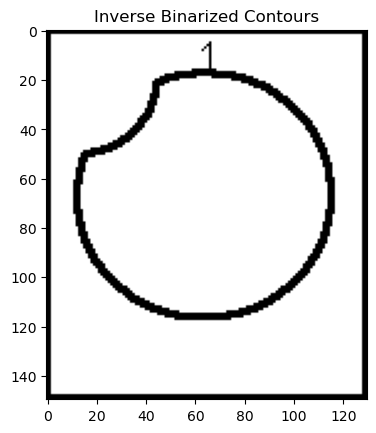

Number of binarized contours:  1


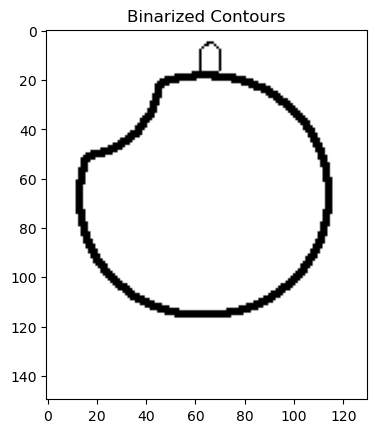

(<matplotlib.image.AxesImage at 0x151a574d0>,
 Text(0.5, 1.0, 'Binarized Contours'),
 None)

In [21]:
contours, hierarchy = cv2.findContours(biInvMat, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
print("Number of inverse binarized contours: ", len(contours))
sketchMat = np.zeros(biInvMat.shape)
sketchMat.fill(255)
cv2.drawContours(sketchMat, contours, -1, 0, 2)
for i in range(len(contours)):
    cv2.putText(sketchMat, str(i), contours[i][0][0], cv2.FONT_HERSHEY_SIMPLEX, 0.6, 0, 1, cv2.LINE_AA)
plt.imshow(sketchMat, 'gray'), plt.title('Inverse Binarized Contours'), plt.show()

contours, hierarchy = cv2.findContours(biMat, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
print("Number of binarized contours: ", len(contours))
sketchMat = np.zeros(biInvMat.shape)
sketchMat.fill(255)
cv2.drawContours(sketchMat, contours, -1, 0, 2)
for i in range(len(contours)):
    cv2.putText(sketchMat, str(i), contours[i][0][0], cv2.FONT_HERSHEY_SIMPLEX, 0.6, 0, 1, cv2.LINE_AA)
plt.imshow(sketchMat, 'gray'), plt.title('Binarized Contours'), plt.show()